In [132]:
import pandas as pd
import numpy as np
import datetime as dt # for date data type
import seaborn as sns # For creating plots
import geopandas as gdp
import matplotlib.pyplot as plt

# Preproccesign and getting a first look at the Data

In [133]:
data = pd.read_csv("Traffic-uus-2.csv")
data

,Time,Scheme type nr,Scheme type_1,Accident type_3,Weather_1,Illumination_2,Road covering condition_1,Road type_2,Road element,Road covering,...,District,GPS X,GPS Y,Curviness,Lat,Lon,Death toll,Individuals,Vehicles,Casualties
0,24.10.2014 08:45:00,104.0,Vehicle conflict with pedestrian,Collision with pedestrian,Clear,Daylight,Dry,Street,Road without special features,Permanent pavement,...,Kesklinna linnaosa,6588678.0,542647.0,Straight road,59.433796,24.751479,0,2,1,1
1,24.10.2014 13:45:00,401.0,Vehicles moving to same direction (not passing),Collision with vehicle moving in front,Cloudy,Daylight,Dry,Street,Y-shaped junction,Permanent pavement,...,Põhja-Tallinna linnaosa,6589522.0,541467.0,Gentle curve,59.441488,24.730850,0,2,2,1
2,08.11.2014 15:10:00,207.0,Single vehicle accident,Collision with vehicle moving in front,Cloudy,Daylight,Dry,Street,Road without special features,Permanent pavement,...,Pirita linnaosa,6593961.0,547646.0,Straight road,59.480681,24.840724,0,2,2,1
3,17.11.2014 17:32:00,606.0,Vehicles from opposite directions,Collision with oncoming vehicle,Cloudy,Night time lighting off,Dry,Supporting road,T-shaped junction,Permanent pavement,...,NaN,6569324.0,516628.0,Gentle curve,59.261884,24.291529,0,2,2,2
4,28.04.2015 07:55:00,505.0,Vehicles from crossing directions,Collision with vehicle from side,Rainfall,Daylight,Wet,Street,T-shaped junction,Permanent pavement,...,Kesklinna linnaosa,6586430.0,541953.0,Straight road,59.413688,24.738815,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12627,21.05.2017 09:35:00,207.0,Single vehicle accident,Collision with vehicle standing in front,Clear,Daylight,Dry,Secondary highway,Road without special features,Permanent pavement,...,Jõõpre küla,6480481.0,519847.0,Straight road,58.464149,24.340068,0,3,2,1
12628,21.05.2017 13:50:00,601.0,Vehicles from opposite directions,Collision with oncoming vehicle,Sun shining low,Daylight,Dry,Main highway,Bridge,Permanent pavement,...,Konuvere küla,6519056.0,524082.0,Straight road,58.810261,24.416737,0,2,3,1
12629,22.05.2017 18:29:00,203.0,Single vehicle accident,Vehicle off the road,Clear,Daylight,Dry,Main highway,Road without special features,Permanent pavement,...,Jaanika küla,6558038.0,519643.0,Gentle curve,59.160443,24.343375,0,1,1,1
12630,22.05.2017 20:02:00,401.0,Vehicles moving to same direction (not passing),Collision with vehicle moving in front,Clear,Daylight,Dry,Street,+-shaped junction,Permanent pavement,...,Tartu linn,NaN,NaN,Straight road,NaN,NaN,0,2,2,2


In [134]:
data.columns

Index(['Time', 'Scheme type nr', 'Scheme type_1', 'Accident type_3',
       'Weather_1', 'Illumination_2', 'Road covering condition_1',
       'Road type_2', 'Road element', 'Road covering', 'Road condition',
       'Road evenness', 'Participant_public vehicle driver',
       'Participant_truck driver', 'Participant_off road vehicle',
       'Participant_motorcyclist', 'Participant_vehicle driver',
       'Participant_moped driver', 'Participant_car driver',
       'Participant_off road vehicle_2', 'Participant_minor',
       'Participant_bus driver', 'Participant_elderly driver (65+)',
       'Participant_new driver', 'Participant_not using safety equipment',
       'Participant_pedestrian', 'Participant_fellow traveller',
       'Participant_cyclist', 'Street (PPA)', 'House nr (PPA)',
       'Local municipality (PPA)', 'Settlement', 'County (PPA)', 'District',
       'GPS X', 'GPS Y', 'Curviness', 'Lat', 'Lon', 'Death toll',
       'Individuals', 'Vehicles', 'Casualties'],
      dtyp

In [135]:
#check and delte columns with one value
print(len(data.columns))
cols = data.columns.tolist()  
for col in cols:
    if len(set(data[col].tolist())) < 2:  
        data = data.drop(col, axis=1)  
print(len(data.columns))  


#check columns with 95% of the same value
num_rows = len(data.index)
low_information_cols = []

for col in data.columns:
    cnts = data[col].value_counts(dropna=False)
    top_pct = (cnts / num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct * 100))
        print(cnts)
        print()
        #drop one of the Participant_off road vehicle columns
        #we can think about dropping columns with more than x nan-values
        

43
43
Participant_off road vehicle: 98.59880%
0.0    12455
NaN       91
1.0       86
Name: Participant_off road vehicle, dtype: int64

Participant_moped driver: 95.59056%
0.0    12075
1.0      466
NaN       91
Name: Participant_moped driver, dtype: int64

Participant_off road vehicle_2: 98.59880%
0.0    12455
NaN       91
1.0       86
Name: Participant_off road vehicle_2, dtype: int64

Death toll: 95.49557%
0    12063
1      536
2       24
3        7
4        2
Name: Death toll, dtype: int64



<AxesSubplot:>

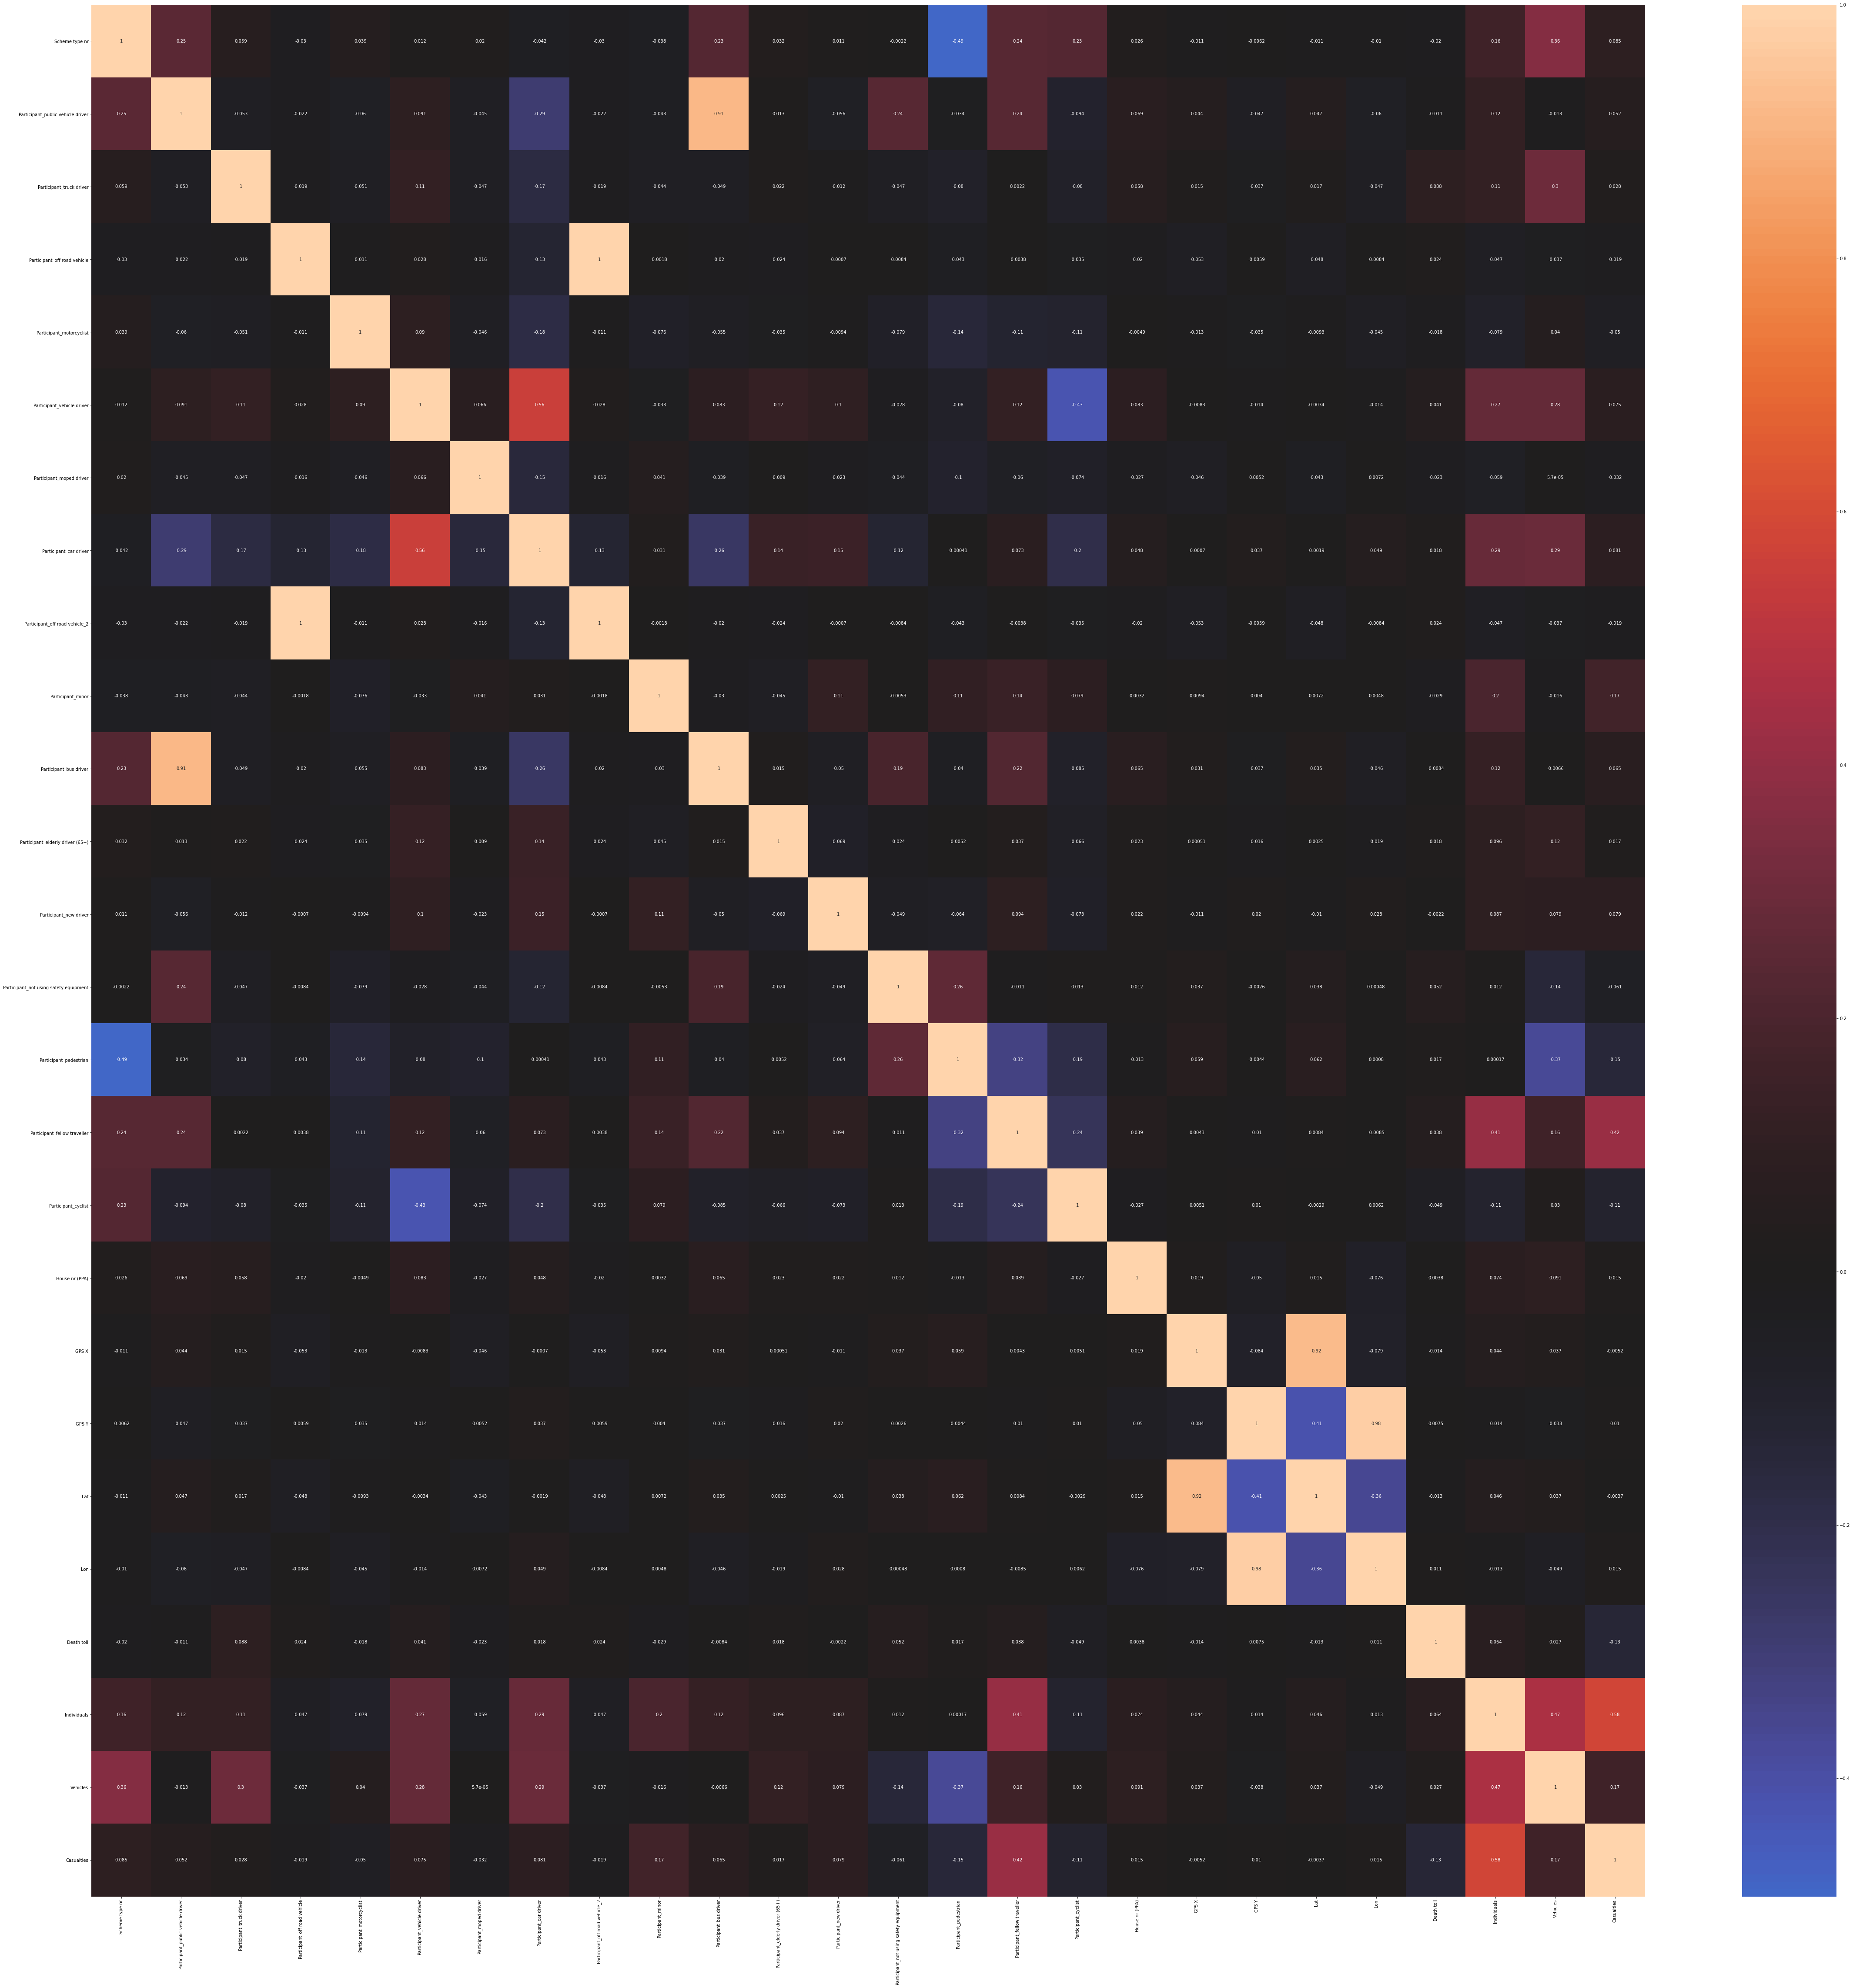

In [136]:
fig, ax = plt.subplots(figsize=(80,80))
sns.heatmap(data.corr(), center=0, annot=True)
#low corralation -> good

<AxesSubplot:>

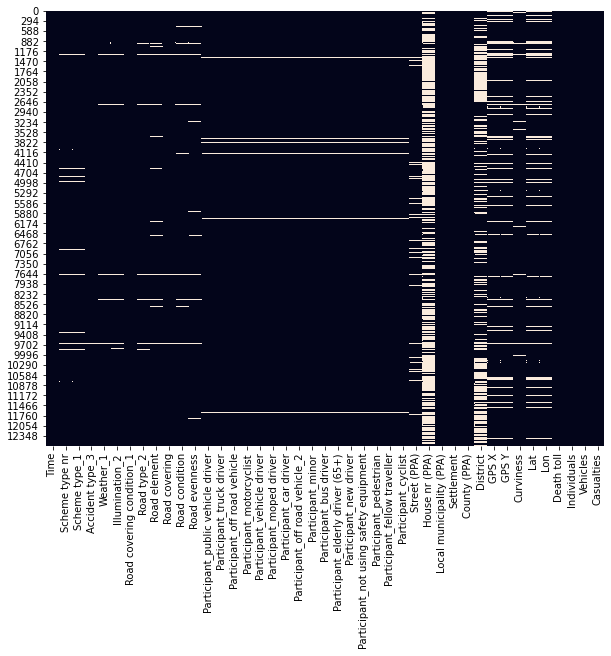

In [137]:
#visualizing nan-values
plt.figure(figsize = (10,8))
sns.heatmap(data.isnull(), cbar=False, xticklabels=1)
#maybe drop house nr and district?

# Goal 1: Find patterns depending on the time of year 

In [138]:
data.Time = pd.to_datetime(data.Time)
data['Time_day']=data.Time.dt.dayofweek #monday=0 ... sunday=6
data['Time_dayofmonth']=data.Time.dt.day
data['Time_month']=data.Time.dt.month
data['Time_year']=data.Time.dt.year
data['Time_hour']=data.Time.dt.hour
data

,Time,Scheme type nr,Scheme type_1,Accident type_3,Weather_1,Illumination_2,Road covering condition_1,Road type_2,Road element,Road covering,...,Lon,Death toll,Individuals,Vehicles,Casualties,Time_day,Time_dayofmonth,Time_month,Time_year,Time_hour
0,2014-10-24 08:45:00,104.0,Vehicle conflict with pedestrian,Collision with pedestrian,Clear,Daylight,Dry,Street,Road without special features,Permanent pavement,...,24.751479,0,2,1,1,4,24,10,2014,8
1,2014-10-24 13:45:00,401.0,Vehicles moving to same direction (not passing),Collision with vehicle moving in front,Cloudy,Daylight,Dry,Street,Y-shaped junction,Permanent pavement,...,24.730850,0,2,2,1,4,24,10,2014,13
2,2014-08-11 15:10:00,207.0,Single vehicle accident,Collision with vehicle moving in front,Cloudy,Daylight,Dry,Street,Road without special features,Permanent pavement,...,24.840724,0,2,2,1,0,11,8,2014,15
3,2014-11-17 17:32:00,606.0,Vehicles from opposite directions,Collision with oncoming vehicle,Cloudy,Night time lighting off,Dry,Supporting road,T-shaped junction,Permanent pavement,...,24.291529,0,2,2,2,0,17,11,2014,17
4,2015-04-28 07:55:00,505.0,Vehicles from crossing directions,Collision with vehicle from side,Rainfall,Daylight,Wet,Street,T-shaped junction,Permanent pavement,...,24.738815,0,2,2,1,1,28,4,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12627,2017-05-21 09:35:00,207.0,Single vehicle accident,Collision with vehicle standing in front,Clear,Daylight,Dry,Secondary highway,Road without special features,Permanent pavement,...,24.340068,0,3,2,1,6,21,5,2017,9
12628,2017-05-21 13:50:00,601.0,Vehicles from opposite directions,Collision with oncoming vehicle,Sun shining low,Daylight,Dry,Main highway,Bridge,Permanent pavement,...,24.416737,0,2,3,1,6,21,5,2017,13
12629,2017-05-22 18:29:00,203.0,Single vehicle accident,Vehicle off the road,Clear,Daylight,Dry,Main highway,Road without special features,Permanent pavement,...,24.343375,0,1,1,1,0,22,5,2017,18
12630,2017-05-22 20:02:00,401.0,Vehicles moving to same direction (not passing),Collision with vehicle moving in front,Clear,Daylight,Dry,Street,+-shaped junction,Permanent pavement,...,NaN,0,2,2,2,0,22,5,2017,20


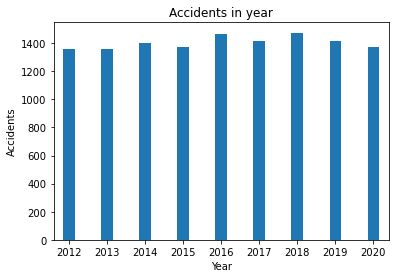

In [5]:
ax = data['Time_year'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Year')
ax.set_title('Accidents in year');

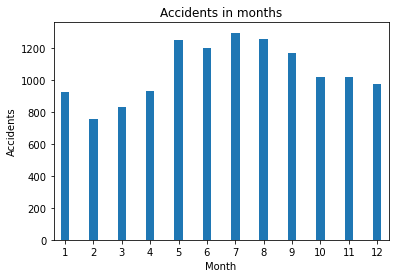

In [139]:
ax = data['Time_month'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Month')
ax.set_title('Accidents in months');

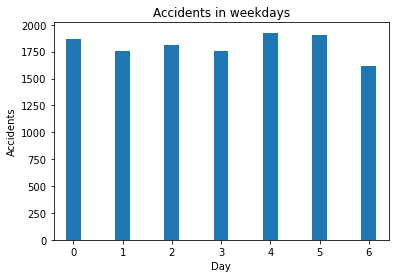

In [7]:
ax = data['Time_day'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Day')
ax.set_title('Accidents in weekdays');

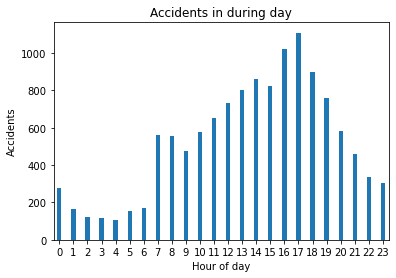

In [8]:
ax = data['Time_hour'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Hour of day')
ax.set_title('Accidents in during day');

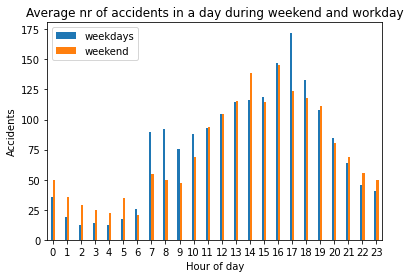

In [9]:
weekdays=data[data['Time_day']<5]['Time_hour'].value_counts().sort_index()/5
weekend=data[data['Time_day']>=5]['Time_hour'].value_counts().sort_index()/2

average=pd.concat([weekdays, weekend], axis=1)
average.columns=['weekdays', 'weekend']
ax=average.plot(kind = 'bar',rot = 0, width = 0.3)

ax.set_ylabel('Accidents')
ax.set_xlabel("Hour of day")
ax.set_title('Average nr of accidents in a day during weekend and workday');

In [10]:
#counting how many accidents happen in fridays and friday the 13-th
friday=len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]!=13) ])
friday13=len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]==13)])

friday,friday13

(1853, 73)

In [11]:
#counting the number of fridays and friday the 13-th
num_fridays = len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]!=13)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_friday13s = len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]==13)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_fridays, num_friday13s

(436, 17)

In [12]:
#average number of accedents on feiday and friday the 13-th
friday/num_fridays, friday13/num_friday13s

(4.25, 4.294117647058823)

In [13]:
# testing if the number of accedents on friday the 13 is higher 
friday=(data[(data['Time_day']==4) & (data["Time_dayofmonth"]!=13) ]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
friday13=(data[(data['Time_day']==4) & (data["Time_dayofmonth"]==13)]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
friday.values

from scipy import stats
print(stats.shapiro(friday.values)) # test for the normality of distibution
print(stats.shapiro(friday13.values))

stats.ttest_ind(friday.values, friday13.values, equal_var = False)

ShapiroResult(statistic=0.935391902923584, pvalue=8.268785504396414e-13)
ShapiroResult(statistic=0.9276058077812195, pvalue=0.19842995703220367)


Ttest_indResult(statistic=-0.08770321635027999, pvalue=0.9310999880271478)

Since the pvalue is higher than .05, we can not reject the null hypothesis and have to conclude that there is not a statistically significant difference on the number of accidents on friday and friday the 13-th. In terms of number of accedents the friday the 13 is not unhappy day

In [14]:
#counting how many accidents happen in midsummerdays and other days
MSD=len(data[(data['Time_month']==6) & (data["Time_dayofmonth"]==23) ])
Other=len(data[~(data['Time_month']==6) & (data["Time_dayofmonth"]==23)])


#counting the number of accedents on midsummerdays and other days
num_MSD = len(data[(data['Time_month']==6) & (data["Time_dayofmonth"]==23)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_other= len(data[~(data['Time_month']==6) & (data["Time_dayofmonth"]==23)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_MSD, num_other

#average number of accedents on midsummerdays and other days
MSD/num_MSD, Other/num_other

(5.111111111111111, 3.8247422680412373)

In [15]:
# testing if the number of accedents on midsummerdays and other days
MSD=(data[(data['Time_month']==6) & (data["Time_dayofmonth"]==23) ]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
Other=(data[~(data['Time_month']==6) & (data["Time_dayofmonth"]==23)]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])


from scipy import stats
print(stats.shapiro(MSD.values)) # test for the normality of distibution
print(stats.shapiro(Other.values))

stats.ttest_ind(MSD.values, Other.values, equal_var = False)

ShapiroResult(statistic=0.826120138168335, pvalue=0.04039105772972107)
ShapiroResult(statistic=0.924606204032898, pvalue=3.256885247537866e-05)


Ttest_indResult(statistic=1.6418324955871573, pvalue=0.13380311083749863)

Although the average number of accendents were rather different the pvalue is still higher than .05, we can not reject the null hypothesis and have to conclude that there is not a statistically significant difference on the number of accidents on midsummerdays and other days. 

In [23]:
summa=data.value_counts(['Time_dayofmonth','Time_month', 'Time_year'])#.sum(['Death toll', 'Individuals', 'Vehicles'])
summa


Time_dayofmonth  Time_month  Time_year
15               6           2013         16
14               9           2013         15
21               8           2015         14
8                10          2020         13
6                2           2018         13
                                          ..
10               11          2017          1
24               12          2017          1
                             2013          1
                 11          2020          1
10               4           2017          1
Length: 3150, dtype: int64

In [28]:
day_stats = data.groupby(['Time_year','Time_month', 'Time_dayofmonth' ]).agg({'Death toll' : ['sum', 'count'], 'Individuals' : ['sum'], 'Vehicles' : ['sum']})
day_stats

Death toll       Individuals Vehicles
                                            sum count         sum      sum
Time_year Time_month Time_dayofmonth                                      
2012      1          1                        0     3           4        3
                     2                        0     3           8        6
                     3                        0     1           2        2
                     4                        0     2           3        2
                     5                        0     7          12        9
...                                         ...   ...         ...      ...
2020      12         25                       0     8          17        9
                     26                       0     4           7        5
                     28                       2     7          14       12
                     30                       0     4           9        6
                     31                       0     3           7        4

[3150 rows x 4 columns]

In [40]:
day_stats.reset_index().sort_values(('Death toll','count'), ascending=False).head(10) #days when most accidents happen (in count column)

Time_year Time_month Time_dayofmonth Death toll       Individuals  \
                                                 sum count         sum   
511       2013          6              15          1    16          18   
599       2013          9              14          5    15          30   
1281      2015          8              21          0    14          24   
2142      2018          2               6          3    13          34   
3071      2020         10               8          0    13          20   
2945      2020          5              30          0    13          23   
2405      2018         11               8          0    12          29   
308       2012         11              12          0    12          24   
1448      2016          2              11          1    12          26   
955       2014          9              19          0    12          21   

     Vehicles  
          sum  
511        16  
599        25  
1281       20  
2142       20  
3071       20  
2945       19  
2405       19  
308        18  
1448       22  
955        17

# Goal 2: Find out what are the main causes for accidents.

<AxesSubplot:xlabel='Scheme type_1'>

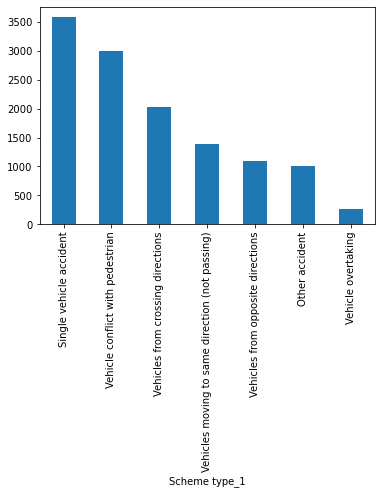

In [33]:
data.value_counts('Scheme type_1').plot(kind="bar")

<AxesSubplot:xlabel='Accident type_3'>

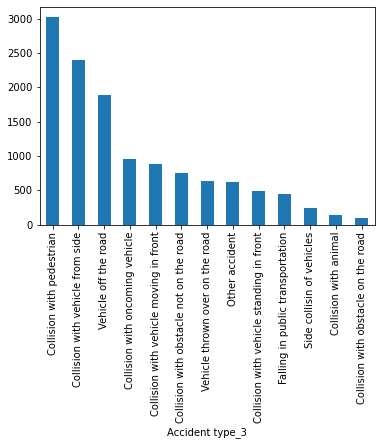

In [35]:
data.value_counts('Accident type_3').plot(kind="bar")

<AxesSubplot:xlabel='Weather_1'>

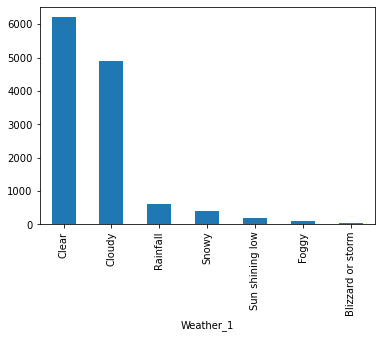

In [34]:
data.value_counts('Weather_1').plot(kind="bar")

<AxesSubplot:xlabel='Illumination_2'>

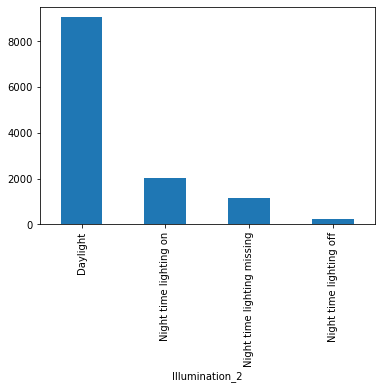

In [38]:
data.value_counts('Illumination_2').plot(kind="bar")

<AxesSubplot:xlabel='Road covering condition_1'>

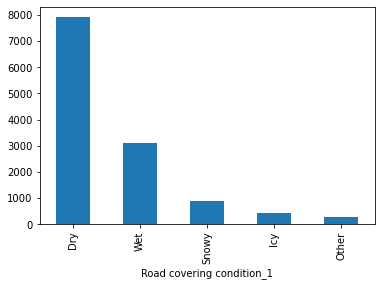

In [40]:
data.value_counts('Road covering condition_1').plot(kind="bar")

<AxesSubplot:xlabel='Road covering'>

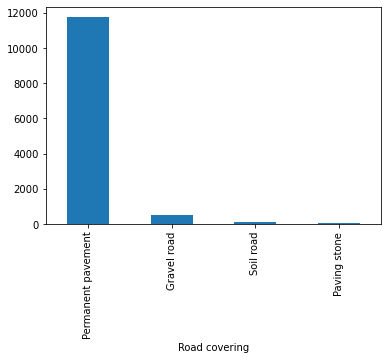

In [41]:
data.value_counts('Road covering').plot(kind="bar")

<AxesSubplot:xlabel='Road element'>

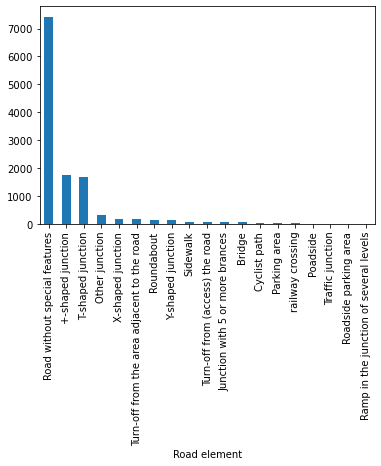

In [43]:
data.value_counts('Road element').plot(kind="bar")

By creating Association Rules of the Features displayed above, we can find out which kind of Combinations of the Featrues cause the most Accidents.

In [78]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

data_apriori = pd.DataFrame(columns= {'Scheme type_1','Road element','Road covering','Road covering condition_1','Weather_1','Accident type_3','Weather_1'})
data_apriori['Scheme type_1'] = data['Scheme type_1']
data_apriori['Road element'] = data['Road element']
data_apriori['Road covering'] = data['Road covering']
data_apriori['Road covering condition_1'] = data['Road covering condition_1']
data_apriori['Weather_1'] = data['Weather_1']
data_apriori['Accident type_3'] = data['Accident type_3']
data_apriori['Weather_1'] = data['Weather_1']



te = TransactionEncoder()
te_ary = te.fit(data_apriori).transform(data_apriori)
data_apriori_enc = pd.DataFrame(te_ary, columns=te.columns_)


freq_itemsets = apriori(data_apriori_enc, min_support=5/len(data_apriori_enc), use_colnames=True)
print(freq_itemsets)
association_rules(freq_itemsets,metric='confidence',min_threshold=0.5)

    support itemsets
0  0.000396      ( )
1  0.000475      (e)
2  0.000396      (t)
3  0.000396   (e,  )
4  0.000396   (t, e)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(e),( ),0.000475,0.000396,0.000396,0.833333,2105.333333,0.000396,5.997625
1,( ),(e),0.000396,0.000475,0.000396,1.000000,2105.333333,0.000396,inf
2,(t),(e),0.000396,0.000475,0.000396,1.000000,2105.333333,0.000396,inf
3,(e),(t),0.000475,0.000396,0.000396,0.833333,2105.333333,0.000396,5.997625


In [79]:
print(data_apriori_enc.value_counts('e'))
print(data_apriori_enc.value_counts('t'))

e    
False    12626
True         6
dtype: int64
t    
False    12627
True         5
dtype: int64


The count of similair Values of 'e' and 't' are very high. This leads to the conclusion that the association rules and frequent item sets do not hold much value.

# Goal 3: Find out what kind of locations have the most accidents.

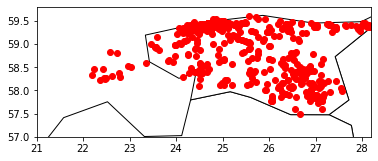

<Figure size 432x216 with 0 Axes>

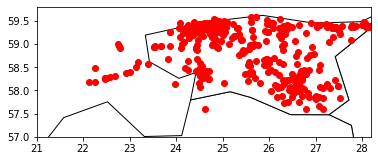

<Figure size 432x216 with 0 Axes>

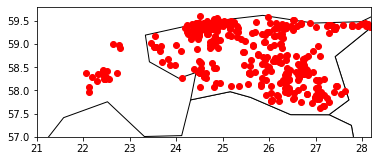

<Figure size 432x216 with 0 Axes>

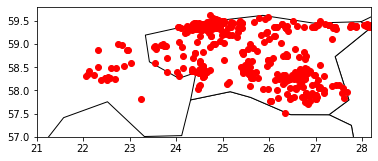

<Figure size 432x216 with 0 Axes>

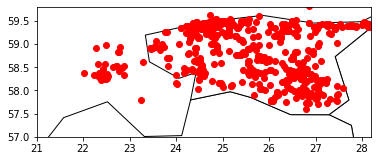

<Figure size 432x216 with 0 Axes>

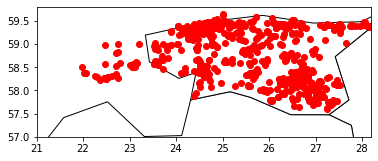

<Figure size 432x216 with 0 Axes>

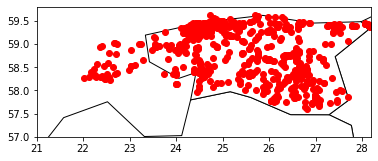

<Figure size 432x216 with 0 Axes>

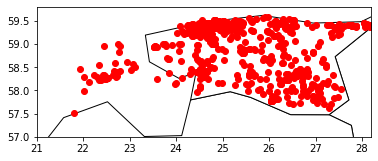

<Figure size 432x216 with 0 Axes>

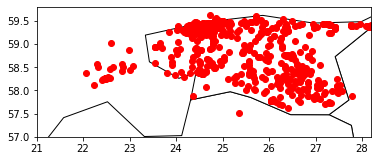

<Figure size 432x216 with 0 Axes>

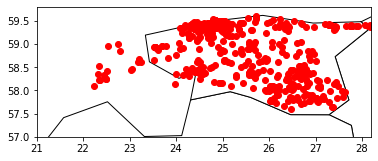

<Figure size 432x216 with 0 Axes>

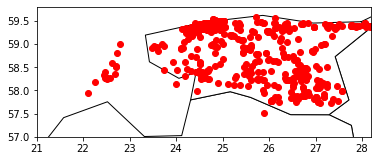

<Figure size 432x216 with 0 Axes>

In [161]:
for i in range(1,12,1):    
    df_sample = data[data['Time_month']==i]
    gdf = gdp.GeoDataFrame(df_sample, geometry=gdp.points_from_xy(df_sample.Lon, df_sample.Lat))
    map_estonia = gdp.read_file(gdp.datasets.get_path('naturalearth_lowres'))
    ax = map_estonia[world.continent == 'Europe'].plot(color='white', edgecolor='black')
    fig= plt.figure(figsize=(6,3))
    ax.set_xlim(21,28.2)
    ax.set_ylim(57,59.8)
    gdf.plot(ax=ax, color='red')
    plt.show()

The accidents are spread all over the country. The area around Tallinn seems to be denser though.  

<AxesSubplot:xlabel='County (PPA)'>

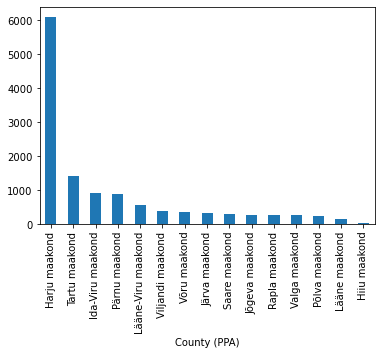

In [73]:
data.value_counts('County (PPA)').plot(kind="bar")

Our first guess was right. In every county there are accidents and more in Tallinn.

Adding the Population Density from Wikipedia to investigate if it is important factor.

In [128]:
county_population = {'Harju maakond':139.83,'Hiiu maakond':9.03,
                     'Ida-Viru maakond':45.17,'Järva maakond':11.28,
                     'Jõgeva maakond':11.18, 'Lääne maakond':11.26,
                     'Lääne-Viru maakond':15.93,'Põlva maakond':13.52,
                     'Pärnu maakond':15.9,'Rapla maakond':12.04,
                     'Saare maakond':11.26,'Tartu maakond':45.78,
                     'Valga maakond':14.71,'Viljandi maakond':13.5,
                     'Võru maakond':12.77}
data = data.assign(col_name='Population Density')
data['Population Density'] = data['County (PPA)']
data['Population Density'] = data['Population Density'].map(county_population)

In [129]:
counts_county = data.value_counts('County (PPA)')
county_population = pd.Series(county_population)
np.corrcoef(counts_county, county_population)

array([[1.        , 0.91602895],
       [0.91602895, 1.        ]])

Our assumption that the amount of accidents and the population density of the country are highly positivly correlated.

# Goal 4:  Find out what kind of locations have the severest accidents.

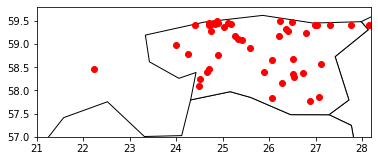

<Figure size 432x216 with 0 Axes>

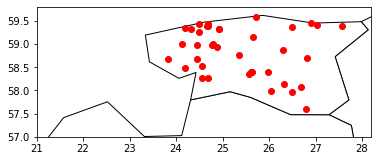

<Figure size 432x216 with 0 Axes>

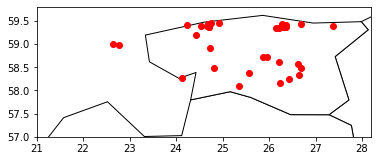

<Figure size 432x216 with 0 Axes>

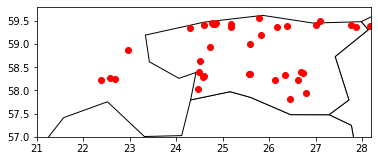

<Figure size 432x216 with 0 Axes>

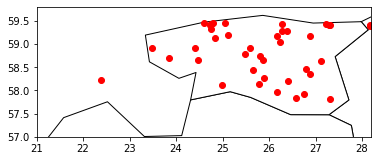

<Figure size 432x216 with 0 Axes>

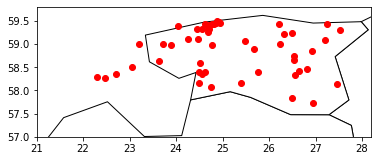

<Figure size 432x216 with 0 Axes>

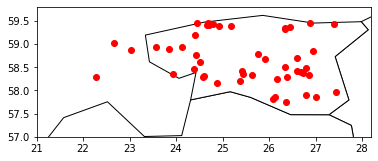

<Figure size 432x216 with 0 Axes>

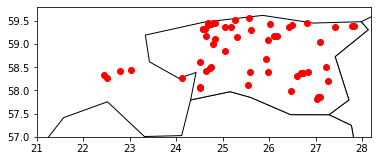

<Figure size 432x216 with 0 Axes>

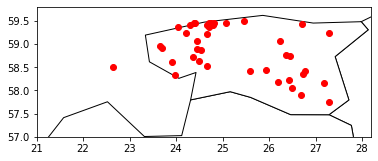

<Figure size 432x216 with 0 Axes>

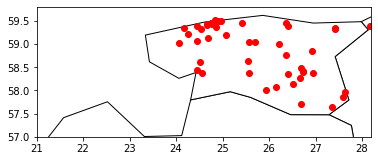

<Figure size 432x216 with 0 Axes>

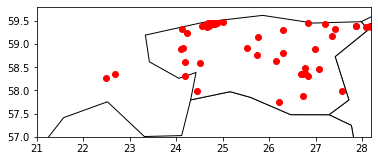

<Figure size 432x216 with 0 Axes>

In [164]:
for i in range(1,12,1):    
    deadly_accidents = data[data['Death toll']>0]
    df_sample = deadly_accidents[deadly_accidents['Time_month']==i]
    gdf = gdp.GeoDataFrame(df_sample, geometry=gdp.points_from_xy(df_sample.Lon, df_sample.Lat))
    map_estonia = gdp.read_file(gdp.datasets.get_path('naturalearth_lowres'))
    ax = map_estonia[world.continent == 'Europe'].plot(color='white', edgecolor='black')
    fig= plt.figure(figsize=(6,3))
    ax.set_xlim(21,28.2)
    ax.set_ylim(57,59.8)
    gdf.plot(ax=ax, color='red')
    plt.show()

<AxesSubplot:xlabel='County (PPA)'>

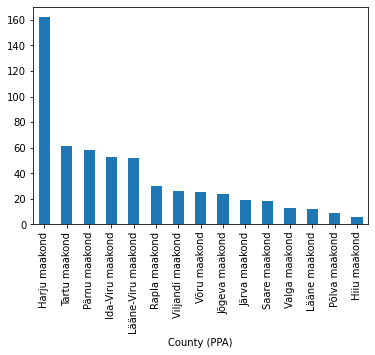

In [155]:
deadly_accidents = data[data['Death toll']>0]
deadly_accidents.value_counts('County (PPA)').plot(kind="bar")

In [167]:
print(len(deadly_accidents)/len(data))

counts_county = deadly_accidents.value_counts('County (PPA)')
county_population = pd.Series(county_population)
np.corrcoef(counts_county, county_population)

0.045044331855604816


array([[1.        , 0.83684892],
       [0.83684892, 1.        ]])

Only 4.5% of the accidents are deadly. Deadly accidents are less correlated with the population density than accidents over all.

<AxesSubplot:xlabel='Scheme type_1'>

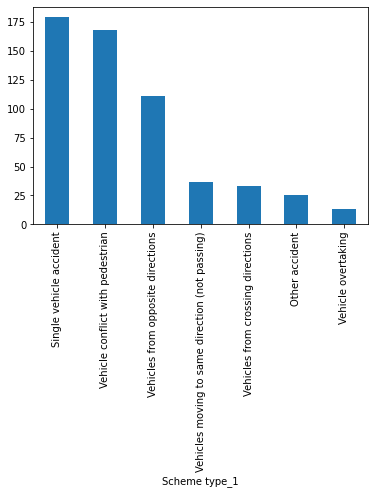

In [184]:
deadly_accidents.value_counts('Scheme type_1').plot(kind="bar")
np.corrcoef(deadly_accidents[], county_population)

<AxesSubplot:xlabel='Accident type_3'>

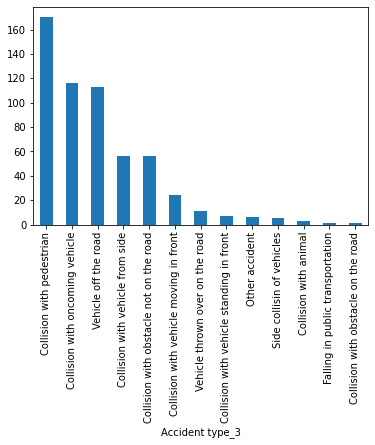

In [185]:
deadly_accidents.value_counts('Accident type_3').plot(kind="bar")

<AxesSubplot:xlabel='Weather_1'>

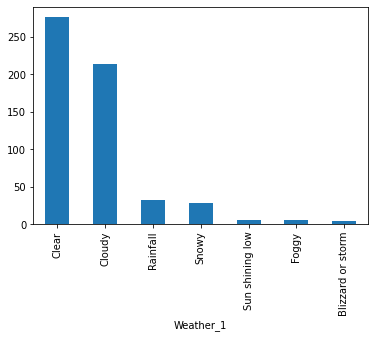

In [186]:
deadly_accidents.value_counts('Weather_1').plot(kind="bar")

<AxesSubplot:xlabel='Illumination_2'>

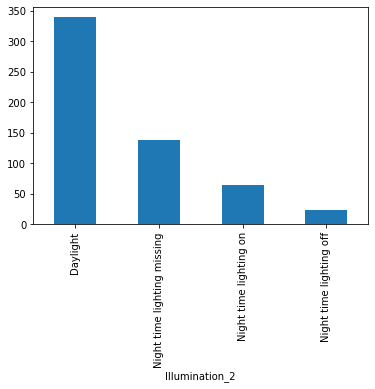

In [187]:
deadly_accidents.value_counts('Illumination_2').plot(kind="bar")

<AxesSubplot:xlabel='Road covering condition_1'>

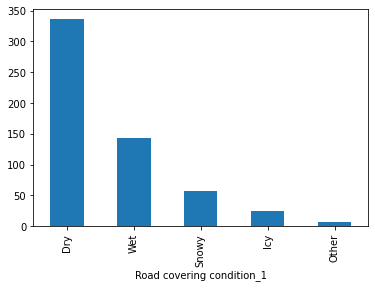

In [188]:
deadly_accidents.value_counts('Road covering condition_1').plot(kind="bar")

<AxesSubplot:xlabel='Road covering'>

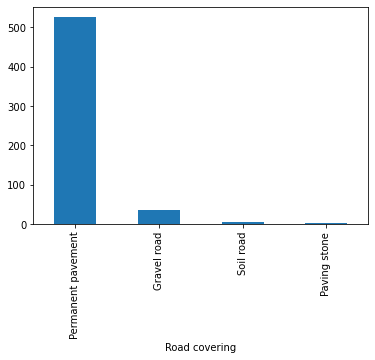

In [189]:
deadly_accidents.value_counts('Road covering').plot(kind="bar")

<AxesSubplot:xlabel='Road element'>

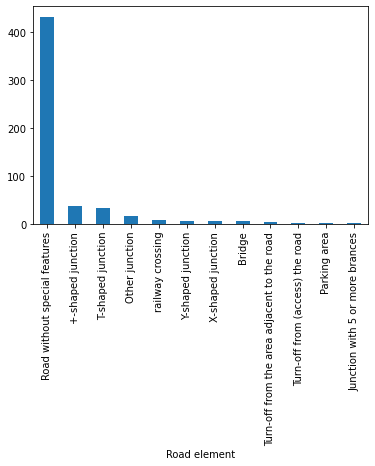

In [190]:
deadly_accidents.value_counts('Road element').plot(kind="bar")